In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.linalg import inv
from scipy.signal import find_peaks
from scipy.integrate import solve_ivp
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

sys.path.append('./../../tensor-dynamic-univariate-ts-pytorch/')
from tensordynamicmodel.visuals import plot_phase_trajectory, delay_embedding_matrix
from tensordynamicmodel.utils import delay_embedding_matrix, diag_mean, prepare_time_series, lorenz

In [2]:
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams.update({"text.usetex": False})

In [3]:
class LorenzSystem:
    def __init__(self, sigma=10.0, beta=8/3, rho=28.0):
        self.sigma = sigma
        self.beta = beta
        self.rho = rho
    
    def equation(self, t, state):
        x, y, z = state
        dx_dt = self.sigma * (y - x)
        dy_dt = x * (self.rho - z) - y
        dz_dt = x * y - self.beta * z
        return [dx_dt, dy_dt, dz_dt]
    
    def generate_data(self, initial_state, t_span, n_points=10000):
        t_eval = np.linspace(t_span[0], t_span[1], n_points)
        solution = solve_ivp(self.equation, t_span, initial_state, 
                           t_eval=t_eval, method='RK45')
        return solution.t, solution.y

In [192]:
def moving_average_simple(data, window_size):
    """
    Простая реализация скользящего среднего
    """
    moving_avg = []
    for i in range(len(data)):
        if i < window_size - 1:
            # Для первых элементов недостаточно данных
            moving_avg.append(np.nan)
        else:
            # Вычисляем среднее для окна
            window = data[i - window_size + 1:i + 1]
            moving_avg.append(np.mean(window))
    return np.array(moving_avg)
    
def make_ts(person, activity):
    pdf_data_all = pd.read_csv(f'./../data/A_DeviceMotion_data/{activity}/sub_{person}.csv').reset_index(drop=True)
    data_list = ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']
    data_list_short = ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']
    pdf_data_all = pdf_data_all[data_list_short]
    xyz = pdf_data_all[data_list_short].to_numpy()
    x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
    return np.sqrt(x**2 + y**2 + z**2)

def negative_acc_ts_alignment(x, trashhold = -2):
    x = (x - x.mean())/(x.var()**.5)
    i_peak, _ = find_peaks(-x)
    i_min_peak = [i for i in i_peak if x[i] <= trashhold]
    return i_min_peak[0]

def prepare_ts(person, activity, negative_trashhold= -2):
    ts = make_ts(person, activity)
    i_min_peak = negative_acc_ts_alignment(ts[500:800], negative_trashhold)
    ts = ts[500+i_min_peak-20:] 
    ts = moving_average_simple(ts, 20)[20:]
    ts = (ts - ts.mean())/(ts.var()**.5)
    return ts

In [193]:
def compute_jacobian_matrix(S_old, S_new):
    """Вычисление матрицы Якоби между двумя фазовыми пространствами"""
    # Решаем задачу линейной регрессии: S_new ≈ S_old*J
    J_est = inv(S_old.T @ S_old) @ S_old.T @ S_new  
    return J_est
    
def jacobian_prediction_model(train_static_params, J_matrices, test_static_params):
    """Модель предсказания матрицы Якоби по параметру rho"""
    # Векторизация матриц Якоби
    J_vecs = np.array([J.flatten() for J in J_matrices])
    
    # Обучение линейной модели
    model = LinearRegression()
    model.fit(rho_values.reshape(-1, 1), J_vecs)
    
    # Предсказание для нового rho
    J_pred_vec = model.predict(np.array([[test_rho]]))
    J_pred = J_pred_vec.reshape(3, 3)
    
    return J_pred

In [195]:
t_span = [0, 500]
initial_state = [1.0, 1.0, 1.0]
ts = LorenzSystem().generate_data(initial_state, t_span)

In [196]:
# person = 1
# wlk_7 wlk_8 wlk_15
# activity = 'wlk_7'
# ts_1 = prepare_ts(3, 'wlk_7')
# ts_2 = prepare_ts(2, 'wlk_7')

ts_1 = make_ts(1, 'wlk_7')
ts_2 = make_ts(2, 'wlk_7')

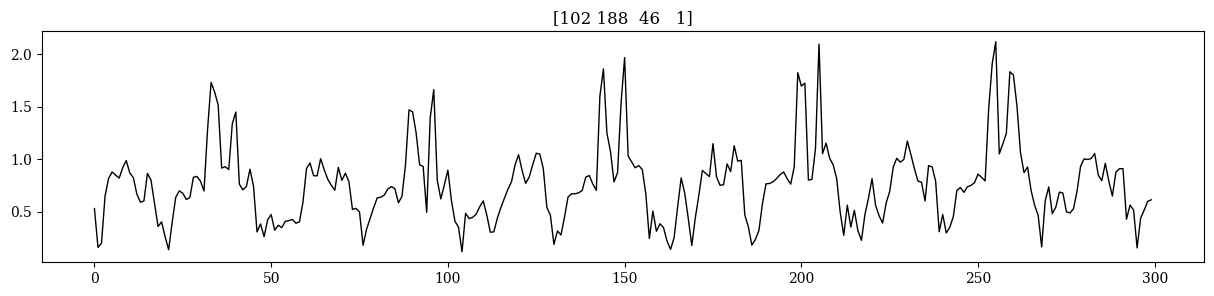

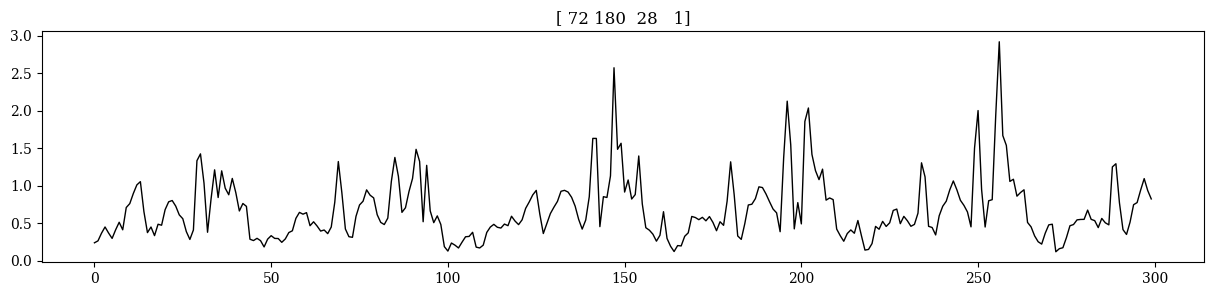

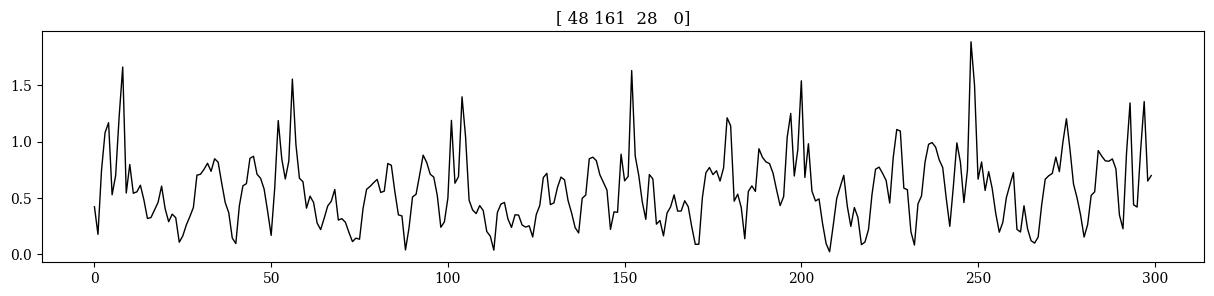

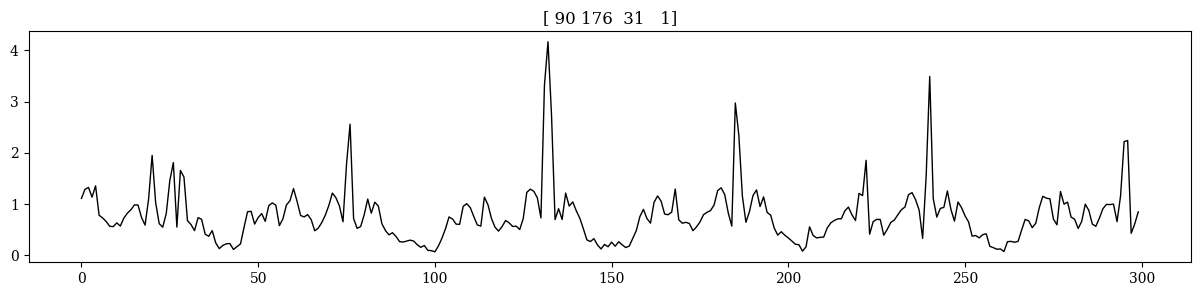

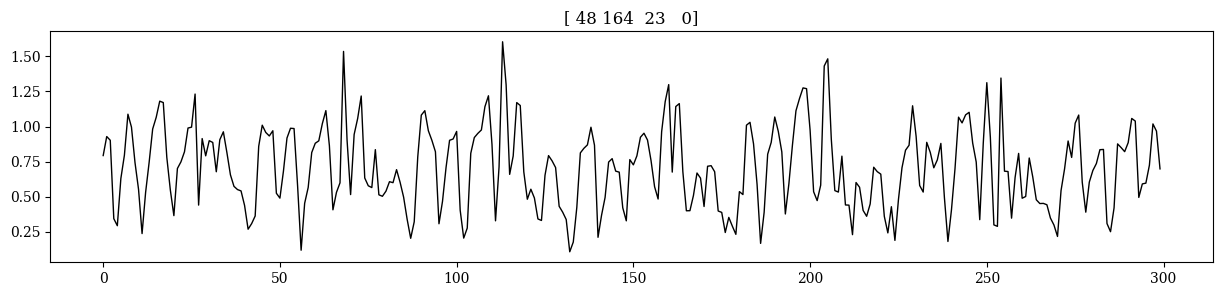

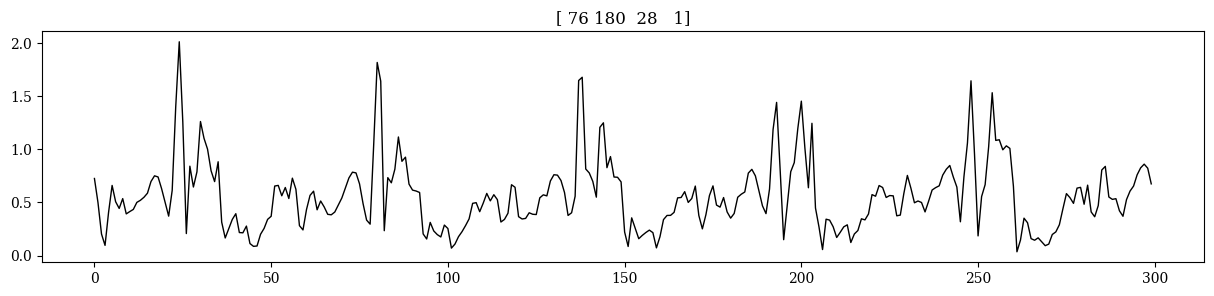

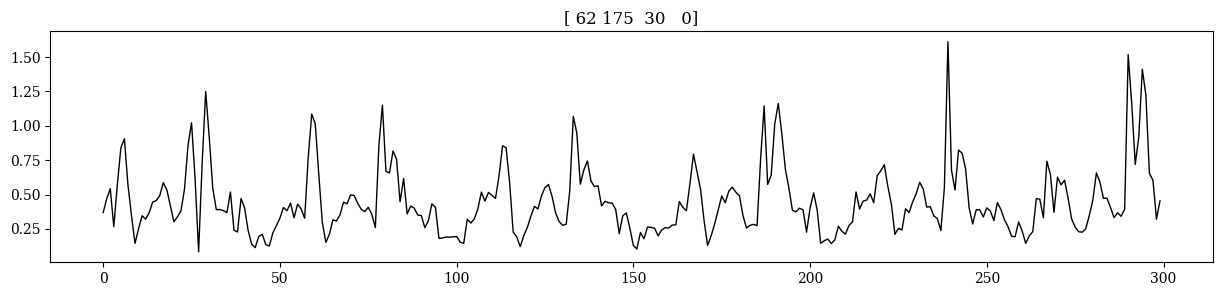

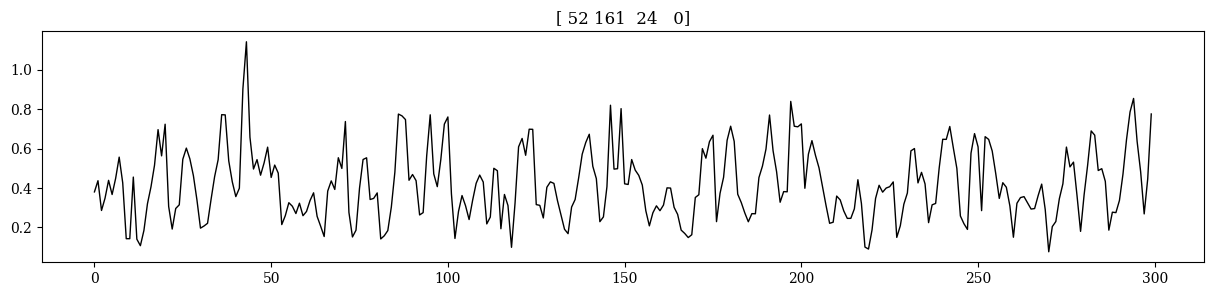

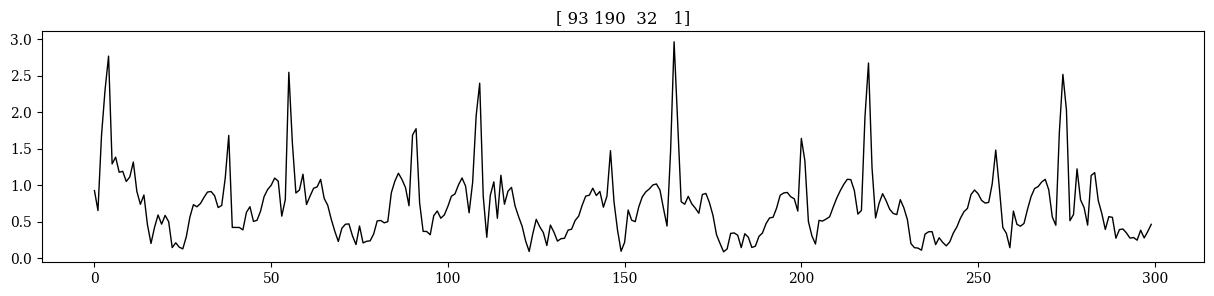

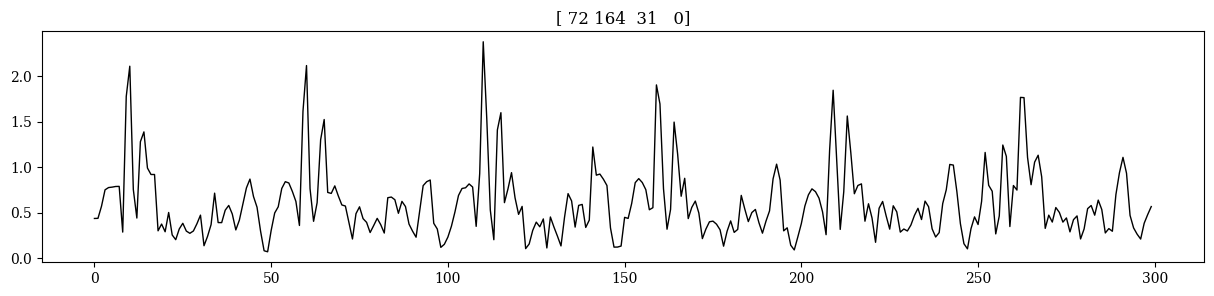

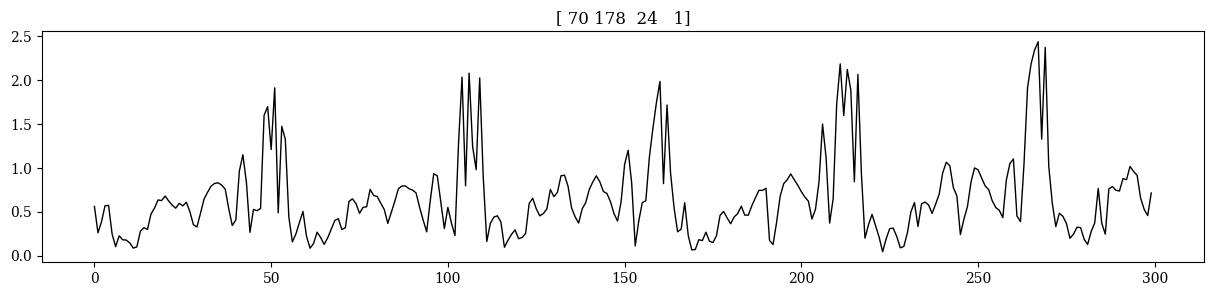

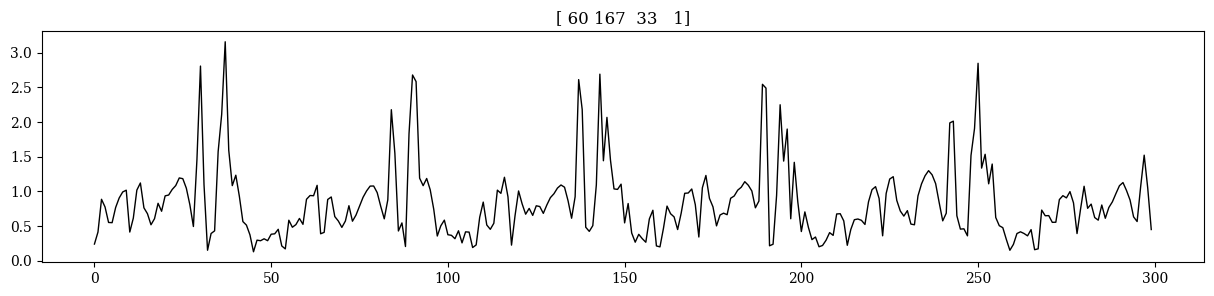

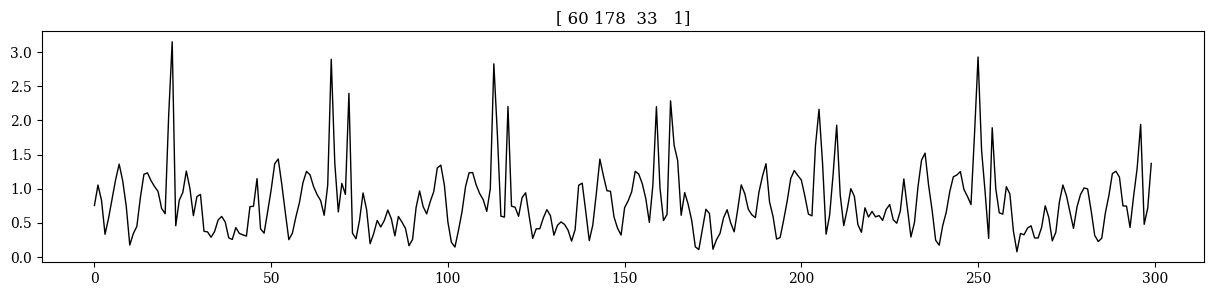

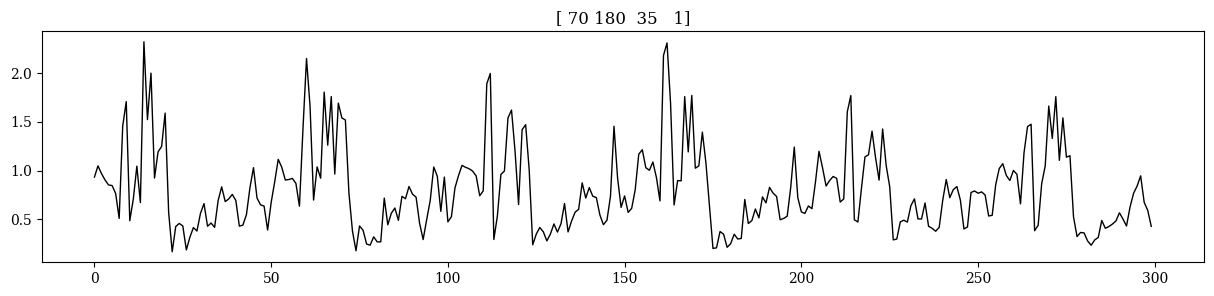

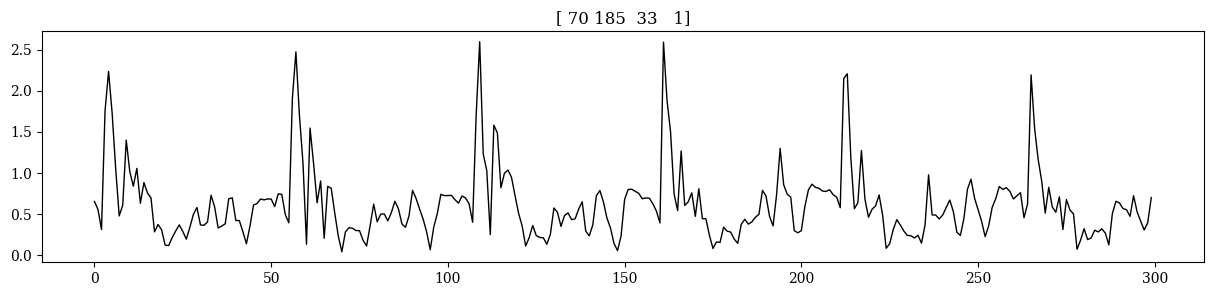

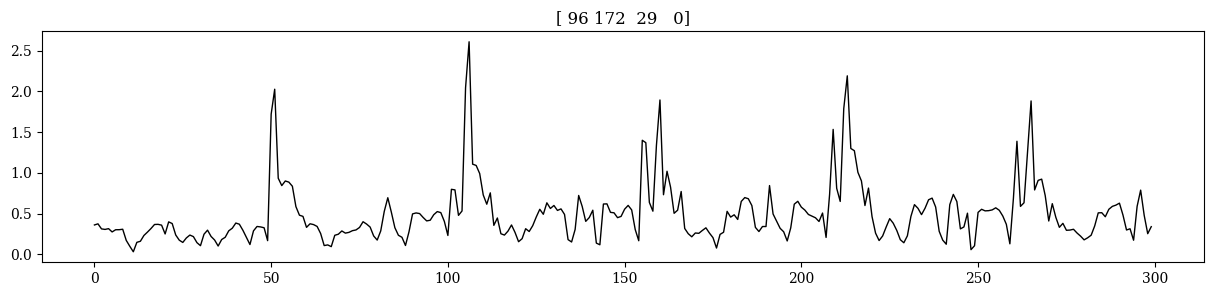

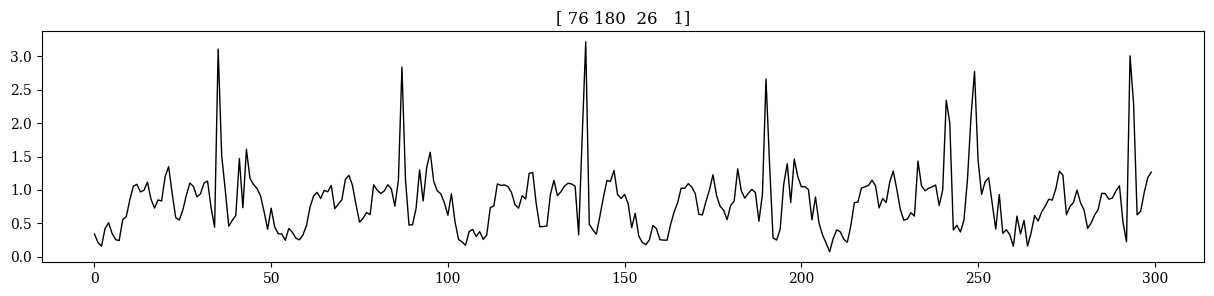

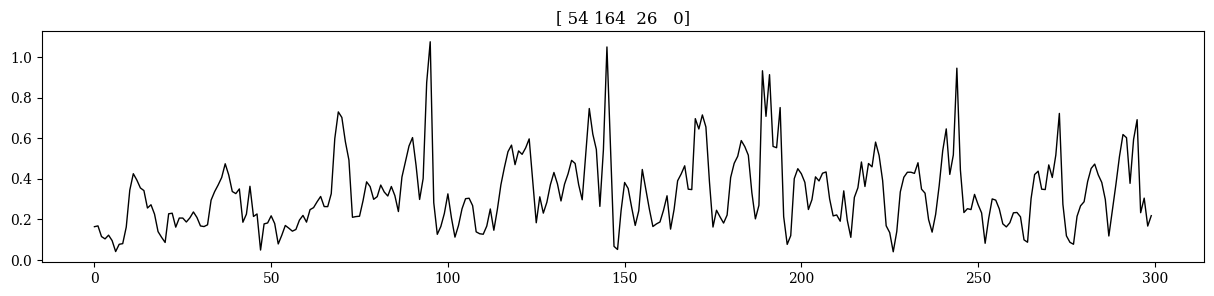

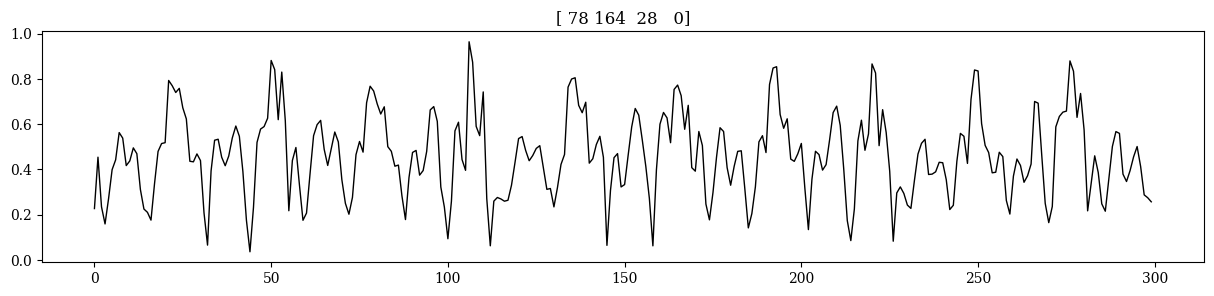

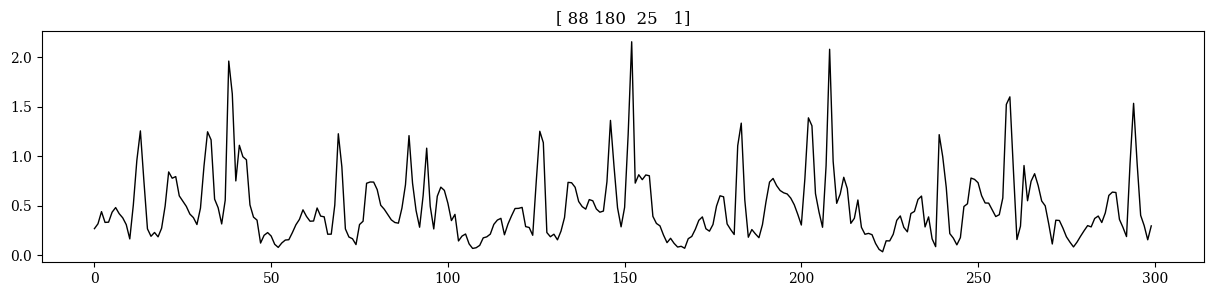

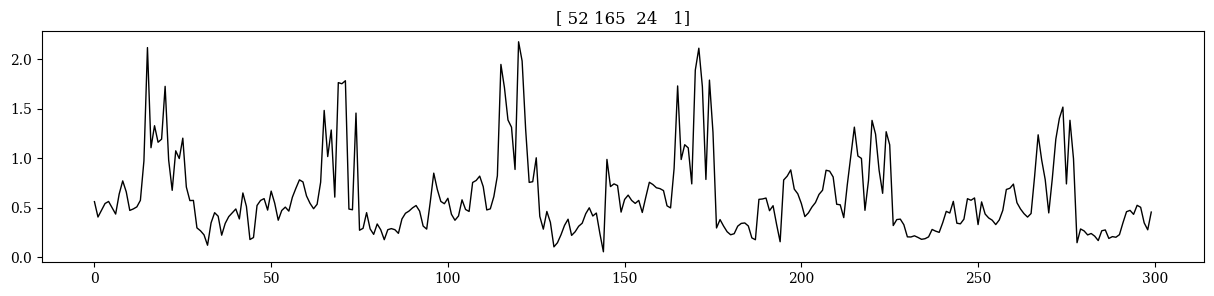

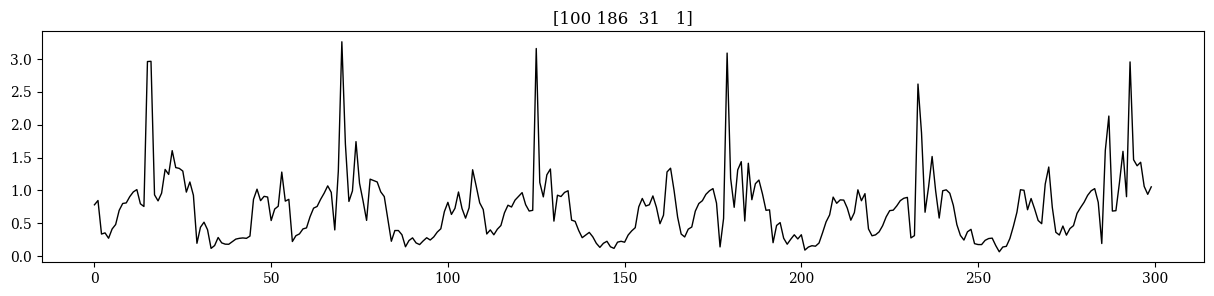

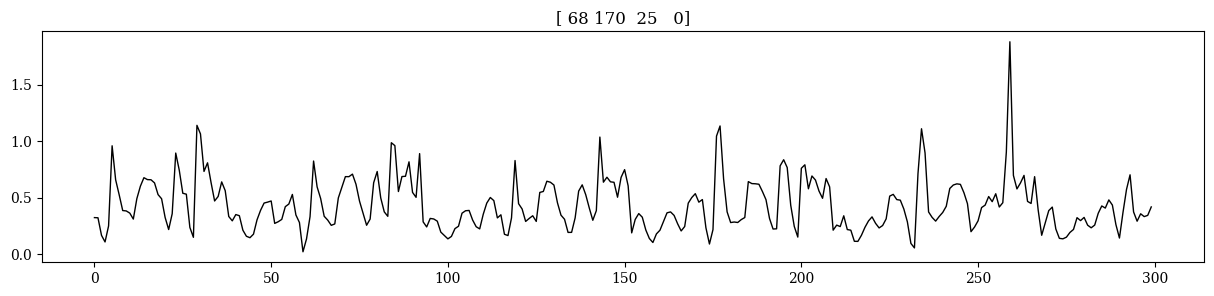

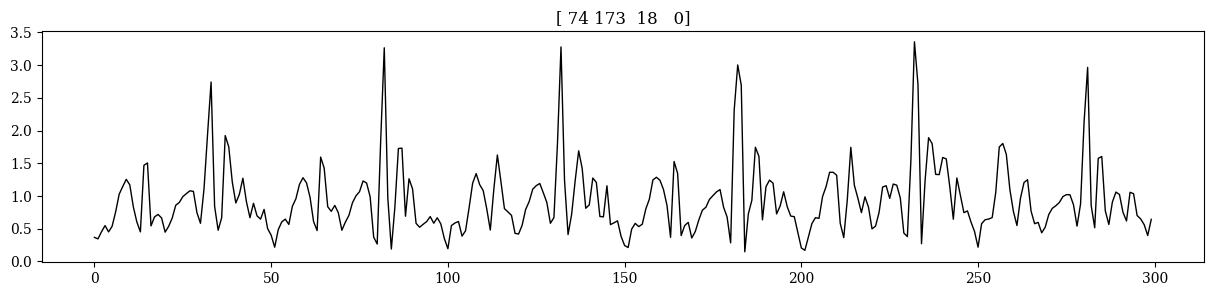

In [202]:
theta_all =  pd.read_csv('./../data/A_DeviceMotion_data/data_subjects_info.csv').groupby('code').max()
for i in range(1,25):
    ts_1 = make_ts(i, 'wlk_7')
    plt.figure(figsize=(15,3))
    plt.plot(ts_1[500:800], color = 'black', ls = '-', lw = 1)
    plt.title(str(theta_all.loc[i].values))
    plt.show()


In [198]:
# x = ts_1[:500]
# peaks, _ = find_peaks(x)
# plt.plot(x)
# plt.plot(peaks, x[peaks], "x")
# plt.plot(np.zeros_like(x), "--", color="gray")
# plt.show()

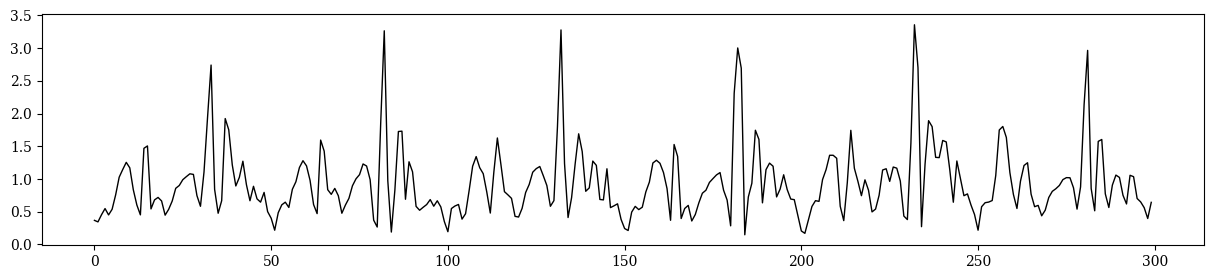

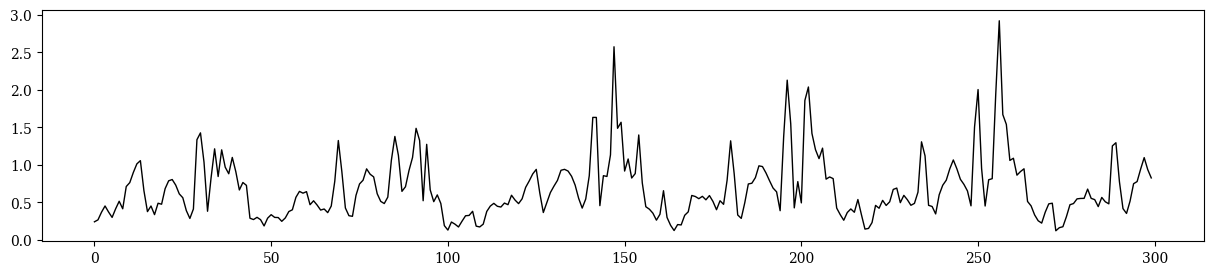

In [199]:
plt.figure(figsize=(15,3))
plt.plot(ts_1[500:800], color = 'black', ls = '-', lw = 1)
plt.show()

plt.figure(figsize=(15,3))
plt.plot(ts_2[500:800], color = 'black', ls = '-', lw = 1)

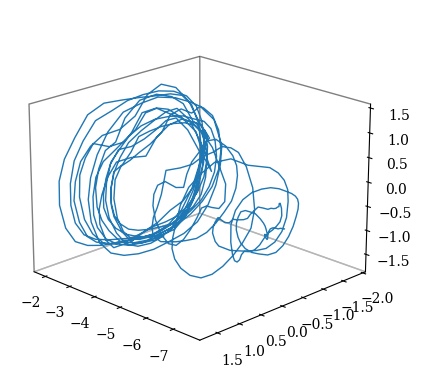

In [200]:
ax = plot_phase_trajectory(PCA(3).fit_transform(delay_embedding_matrix(ts_1, 50))[:500,:], rotation=(0, 0, 0))
# ax.set_xlim(-5,5)
# ax.set_ylim(-5,5)
# ax.set_zlim(-5,5)

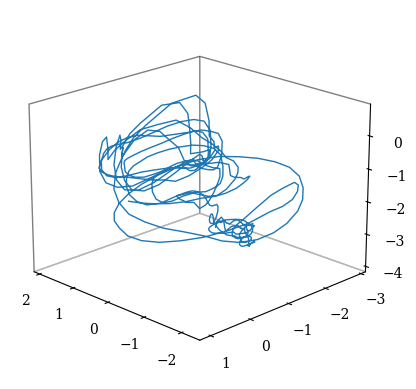

In [201]:
ax = plot_phase_trajectory(PCA(5).fit_transform(delay_embedding_matrix(ts_2, 50))[:500,2:], rotation=(0, 0, 0))
# ax.set_xlim(-5,5)
# ax.set_ylim(-5,5)
# ax.set_zlim(-5,5)

In [81]:
theta_all =  pd.read_csv('./../data/A_DeviceMotion_data/data_subjects_info.csv').groupby('code').max()
theta_all = (theta_all - theta_all.mean())/(theta_all.var()**.5)
theta_columns = ['weight', 'height', 'age', 'gender']

In [96]:
list_S = []
list_model = []
min_lenth = np.inf
p = 6


for person in range(1,21):
    ts = prepare_ts(person, 'wlk_7')
    X = delay_embedding_matrix(ts, 50)
    cur_min_lenth = X.shape[0]
    if cur_min_lenth < min_lenth:
        min_lenth = cur_min_lenth
        
    model = PCA(p).fit(X)
    S = model.transform(X)


    list_model.append(model)
    list_S.append(S)

In [97]:
person_index = [(i, j) for i in range(0, 20) for j in range(0, 20) if i != j]

In [98]:
matrix_J_train = []
matrix_theta_train = []

for i,j in person_index:
    J = compute_jacobian_matrix( S_new=list_S[j][:min_lenth,:], S_old=list_S[i][:min_lenth,:])
    matrix_J_train.append(J)
    break

In [99]:
J.round(2)

array([[ 0.  ,  0.02, -0.01,  0.  , -0.  , -0.  ],
       [-0.99, -0.07,  0.01,  0.01,  0.  , -0.  ],
       [ 0.09, -1.02,  0.01,  0.  ,  0.02, -0.  ],
       [-0.35,  0.01, -0.11, -0.04,  0.03, -0.03],
       [-0.06, -0.  , -0.03, -0.04,  0.1 ,  0.07],
       [-0.01, -0.02, -0.02,  0.09,  0.01,  0.09]])

In [100]:
list_S[j][:min_lenth,:]

array([[ 1.55287205, -1.2542719 , -0.47254807,  0.54944447,  0.00661047,
        -0.21420031],
       [ 1.39893266, -1.33885687, -0.56670946,  0.49236457,  0.0952382 ,
        -0.29656972],
       [ 1.23046724, -1.40617443, -0.65173943,  0.38660729,  0.15052779,
        -0.32521372],
       ...,
       [ 0.32145524,  1.48893747,  0.0794082 , -0.19223398,  0.79521811,
         0.18908016],
       [ 0.48144107,  1.39631731,  0.14222897, -0.46335035,  0.7492977 ,
         0.162116  ],
       [ 0.63143477,  1.28287901,  0.23667884, -0.68782767,  0.61700523,
         0.10147946]], shape=(2189, 6))

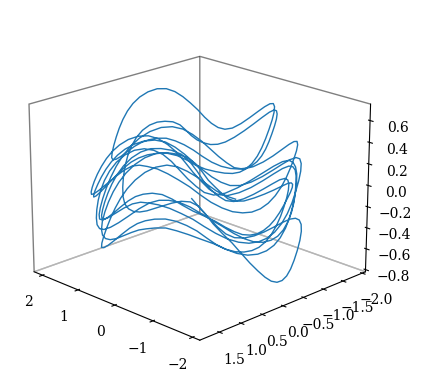

In [103]:
ax = plot_phase_trajectory(phase_trajectory=(list_S[j][:min_lenth,:])[:500,:3], rotation=(0, 0, 0))

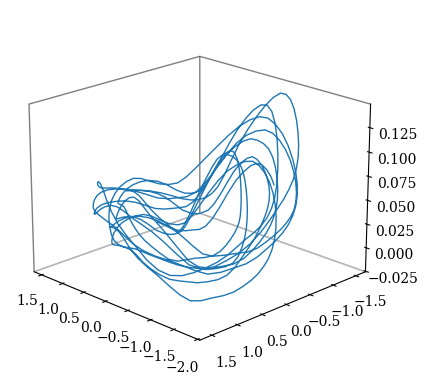

In [105]:
ax = plot_phase_trajectory(phase_trajectory=(list_S[i][:min_lenth,:] @ J)[:500,:3], rotation=(0, 0, 0))

In [ ]:
for person in range(1,21):

In [ ]:
theta_all.loc[1].values

In [ ]:
for i, j in person_index:
    i,j

In [ ]:
len(person_index)

In [ ]:







# Параметры эксперимента
dimension = 3
delay = 10
n_points = 5000
t_span = [0, 50]

# Генерация данных для различных значений rho
rho_values = np.array([20, 24, 28, 32, 36, 40])
systems = []
phase_spaces = []

print("Генерация данных и построение фазовых пространств...")
for rho in rho_values:
    # Создание системы Лоренца
    system = LorenzSystem(rho=rho)
    systems.append(system)
    
    # Генерация данных
    initial_state = [1.0, 1.0, 1.0]
    t, states = system.generate_data(initial_state, t_span, n_points)
    
    # Временные задержки для x-координаты
    x_signal = states[0, :]
    embedded = time_delay_embedding(x_signal, dimension, delay)
    
    # PCA для снижения размерности
    pca = PCA(n_components=3)
    phase_space = pca.fit_transform(embedded.T).T
    phase_spaces.append(phase_space)
    
    print(f"ρ = {rho}: объясненная дисперсия = {pca.explained_variance_ratio_.sum():.3f}")

# Вычисление матриц Якоби между системами
print("\nВычисление матриц Якоби...")
J_matrices = []
base_system_idx = 2  # Используем систему с ρ=28 как базовую

for i, rho in enumerate(rho_values):
    if i != base_system_idx:
        J = compute_jacobian_matrix(phase_spaces[base_system_idx], phase_spaces[i])
        J_matrices.append(J)
        print(f"J для ρ={rho} относительно ρ=28 вычислена")

# Обучение модели предсказания матриц Якоби
print("\nОбучение модели предсказания матриц Якоби...")
train_rho = rho_values[rho_values != 28]
test_rho = 30  # Тестовое значение

J_pred = jacobian_prediction_model(train_rho, J_matrices, test_rho)

# Валидация: создание системы с тестовым ρ и сравнение
print(f"\nВалидация для ρ = {test_rho}")
test_system = LorenzSystem(rho=test_rho)
t_test, states_test = test_system.generate_data(initial_state, t_span, n_points)

# Построение фазового пространства для тестовой системы
x_signal_test = states_test[0, :]
embedded_test = time_delay_embedding(x_signal_test, dimension, delay)
pca_test = PCA(n_components=3)
phase_space_test_true = pca_test.fit_transform(embedded_test.T).T

# Предсказание фазового пространства через матрицу Якоби
phase_space_test_pred = J_pred @ phase_spaces[base_system_idx]

# Визуализация результатов
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 3, figure=fig)

# Исходные фазовые пространства
ax1 = fig.add_subplot(gs[0, 0], projection='3d')
for i, rho in enumerate(rho_values[:3]):
    phase_space = phase_spaces[i]
    ax1.plot(phase_space[0, :1000], phase_space[1, :1000], phase_space[2, :1000], 
             alpha=0.7, label=f'ρ={rho}')
ax1.set_title('Исходные фазовые пространства')
ax1.legend()

# Матрицы Якоби
ax2 = fig.add_subplot(gs[0, 1])
J_heatmap = ax2.imshow(J_pred, cmap='coolwarm', aspect='auto')
plt.colorbar(J_heatmap, ax=ax2)
ax2.set_title('Предсказанная матрица Якоби\nдля ρ=30')
ax2.set_xticks([0, 1, 2])
ax2.set_yticks([0, 1, 2])
ax2.set_xticklabels(['x', 'y', 'z'])
ax2.set_yticklabels(['x', 'y', 'z'])

# Сравнение истинного и предсказанного фазового пространства
ax3 = fig.add_subplot(gs[0, 2], projection='3d')
ax3.plot(phase_space_test_true[0, :1000], phase_space_test_true[1, :1000], 
         phase_space_test_true[2, :1000], 'b-', alpha=0.5, label='Истинное')
ax3.plot(phase_space_test_pred[0, :1000], phase_space_test_pred[1, :1000], 
         phase_space_test_pred[2, :1000], 'r--', alpha=0.7, label='Предсказанное')
ax3.set_title('Сравнение фазовых пространств\nдля ρ=30')
ax3.legend()

# Ошибка предсказания
ax4 = fig.add_subplot(gs[1, :])
error = np.linalg.norm(phase_space_test_true - phase_space_test_pred, axis=0)
ax4.plot(error[:1000])
ax4.set_title('Норма ошибки предсказания по времени')
ax4.set_xlabel('Временной шаг')
ax4.set_ylabel('||S_true - S_pred||')

plt.tight_layout()
plt.show()

# Количественная оценка
mse = np.mean(error**2)
print(f"\nРезультаты эксперимента:")
print(f"Среднеквадратичная ошибка предсказания: {mse:.6f}")
print(f"Средняя ошибка: {np.mean(error):.6f}")
print(f"Максимальная ошибка: {np.max(error):.6f}")

# Анализ чувствительности
print("\nАнализ чувствительности к параметру ρ:")
test_rho_range = np.arange(25, 41, 1)
errors = []

for rho_test in test_rho_range:
    J_pred_test = jacobian_prediction_model(train_rho, J_matrices, rho_test)
    phase_space_pred_test = J_pred_test @ phase_spaces[base_system_idx]
    
    # Генерация истинных данных для этого rho
    test_system_temp = LorenzSystem(rho=rho_test)
    _, states_temp = test_system_temp.generate_data(initial_state, [0, 10], 2000)
    x_signal_temp = states_temp[0, :]
    embedded_temp = time_delay_embedding(x_signal_temp, dimension, delay)
    pca_temp = PCA(n_components=3)
    phase_space_true_temp = pca_temp.fit_transform(embedded_temp.T).T
    
    error_temp = np.mean(np.linalg.norm(phase_space_true_temp - phase_space_pred_test, axis=0))
    errors.append(error_temp)

plt.figure(figsize=(10, 6))
plt.plot(test_rho_range, errors, 'bo-')
plt.xlabel('Параметр ρ')
plt.ylabel('Средняя ошибка предсказания')
plt.title('Зависимость ошибки предсказания от параметра ρ')
plt.grid(True)
plt.show()